In [4]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.Tag_and_icon_search import (
    ElectricalSymbolDetector,
    run_detection_pipeline,
    Detection
)

from utils.icon_filtering import (
    filter_detections,
    draw_filtered_detections,
    analyze_detection_distribution,
    visualize_detection_stats    
)

from dotenv import load_dotenv
load_dotenv()

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

print("✓ Imports successful")


from google import genai
from google.genai import types

client = genai.Client()
from utils.pdf_to_image import pdf_to_images

✓ Imports successful


In [5]:
template_image_path = "test_drawings/output/page_15.png"  
search_image_path = "test_drawings/output/page_9.png"
output_path = "test_drawings/output_images/output"


# template_image_path = "test_drawings/output_images/drawing_images/page_2_cl1.png"  
# search_image_path = "test_drawings/output_images/drawing_images/page_2_cl1.png"

# template_image_path = "test_drawings/output/page_32.png"
# search_image_path = "test_drawings/output/page_32.png"

# threshold = 0.85
# 
tag_threshold=0.7
icon_threshold=0.5    
nms_threshold = 0.3   

max_display_size = 2000  
                        
# scales = [0.95, 0.96, 0.99, 1, 1.11]

# scales = [0.7, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2, 1.3]
# scales = [1,1.3]
rotations = list(np.linspace(0, 315, num=16, dtype=int))


icon_scales = [0.7, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2, 1.3]
tag_scales = [0.9, 1, 1.1]
icon_rotations= rotations = list(np.linspace(0, 315, num=8, dtype=int))
tag_rotations=[0, 90, 270]


# Output settings
save_output = True
output_path = None  # None = auto-generate name

print(f"Configuration loaded:")
print(f"  Template Image: {template_image_path}")
print(f"  Search Image: {search_image_path}")
print(f"  NMS Threshold: {nms_threshold}")
print(f"  Max Display Size: {max_display_size}px")

Configuration loaded:
  Template Image: test_drawings/output/page_15.png
  Search Image: test_drawings/output/page_9.png
  NMS Threshold: 0.3
  Max Display Size: 2000px


In [6]:
results = run_detection_pipeline(
    template_image_path=template_image_path,
    search_image_path=search_image_path,
    tag_threshold=tag_threshold,
    icon_threshold=icon_threshold,
    tag_scales=tag_scales,
    icon_scales=icon_scales,
    tag_rotations=tag_rotations,
    icon_rotations=icon_rotations,
    nms_threshold=nms_threshold,
    save_output=save_output,
    output_path=output_path,
    max_display_size=max_display_size,
)

STEP 1: SELECT TEMPLATE SYMBOL

TEMPLATE COLLECTION MODE
Enter 'tag' to select a tag template (will ask for name)
Enter 'icon' to select the icon template (ends collection)


Selecting TAG template: 'BF3'

STEP 1: SELECT REFERENCE AREA (Rough Selection)
Instructions:
  - Draw a bounding box around the general area of the symbol
  - Don't worry about being precise - just capture the symbol area
  - Press SPACE or ENTER to confirm
  - Press 'c' to cancel

Image resized for display: 10800x7200 -> 1200x800
Scale factor: 0.111

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
✓ Step 1 complete!
  Rough area selected: 180x171 pixels
  Position: (792, 4347)

STEP 2: REFINE SELECTION (Tight Crop)
Instructions:
  - You'll see a ZOOMED view of the area you selected
  - Draw a TIGHT bounding box around ONLY the symbol
  - Exclude any extra whitespace or background
  - This precise crop improves detection accuracy
  - Press SPACE or ENTER to con

In [12]:
tag_detections = results['tag_detections']
icon_detections = results['icon_detections']
all_detections = results['all_detections']
result_image = results['result_image']
detector = results['detector']

In [5]:
all_detections

[Detection(bbox=(np.int64(9557), np.int64(2921), 89, 33), confidence=0.9296985864639282, scale=1, rotation=np.int64(0), center=(np.int64(9601), np.int64(2937)), tag_name='LF-2', template_type='tag'),
 Detection(bbox=(np.int64(10607), np.int64(2921), 89, 33), confidence=0.9296919703483582, scale=1, rotation=np.int64(0), center=(np.int64(10651), np.int64(2937)), tag_name='LF-2', template_type='tag'),
 Detection(bbox=(np.int64(11657), np.int64(2921), 89, 33), confidence=0.9296897649765015, scale=1, rotation=np.int64(0), center=(np.int64(11701), np.int64(2937)), tag_name='LF-2', template_type='tag'),
 Detection(bbox=(np.int64(2375), np.int64(9327), 89, 33), confidence=0.9148999452590942, scale=1, rotation=np.int64(0), center=(np.int64(2419), np.int64(9343)), tag_name='LF-2', template_type='tag'),
 Detection(bbox=(np.int64(2375), np.int64(9715), 89, 33), confidence=0.9148999452590942, scale=1, rotation=np.int64(0), center=(np.int64(2419), np.int64(9731)), tag_name='LF-2', template_type='tag

In [6]:
# Save results as csv

import pandas as pd

# Assuming your Detection class is already defined and all_detections list exists

# Convert list of Detection objects to list of dicts
data = [det.__dict__ for det in all_detections]

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("detections_page32_light.csv", index=False)

print("Saved detections to detections.csv")


Saved detections to detections.csv


In [13]:
import pandas as pd

# Assuming 'all_detections' is your list of Detection objects

data = []
for idx, det in enumerate(all_detections):
    # Unpack bbox and center as separate numeric columns
    x, y, w, h = det.bbox
    cx, cy = det.center

    data.append({
        'Symbol_ID': idx + 1,
        'BBox_X': int(x),
        'BBox_Y': int(y),
        'BBox_Width': int(w),
        'BBox_Height': int(h),
        'Center_X': int(cx),
        'Center_Y': int(cy),
        'Confidence': float(det.confidence),
        'Scale': float(det.scale),
        'Rotation': int(det.rotation),
        'Tag_Name': det.tag_name,
        'Template_Type': det.template_type
    })

# Create DataFrame
df = pd.DataFrame(data)

# Save CSV (using image_path if defined)
csv_path = 'page_11_light.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Detection data exported to: {csv_path}")



✓ Detection data exported to: page_11_light.csv


Original Detection Results:


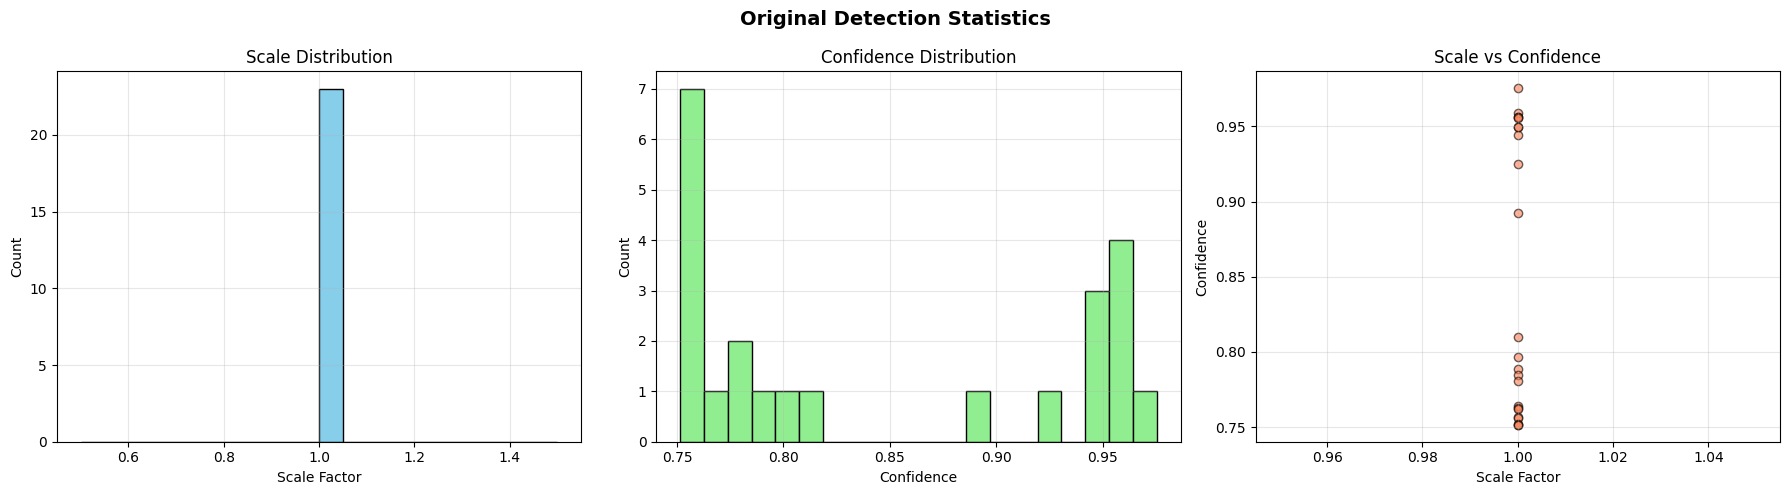


Original Detection Statistics
Total detections: 23
Confidence range: 0.751 - 0.975
Average confidence: 0.847
Scale range: 1.00 - 1.00

Detections per scale:
  Scale 1.00x: 23 detections



In [13]:
print("Original Detection Results:")
visualize_detection_stats(tag_detections, title="Original Detection Statistics")

Original Detection Results:


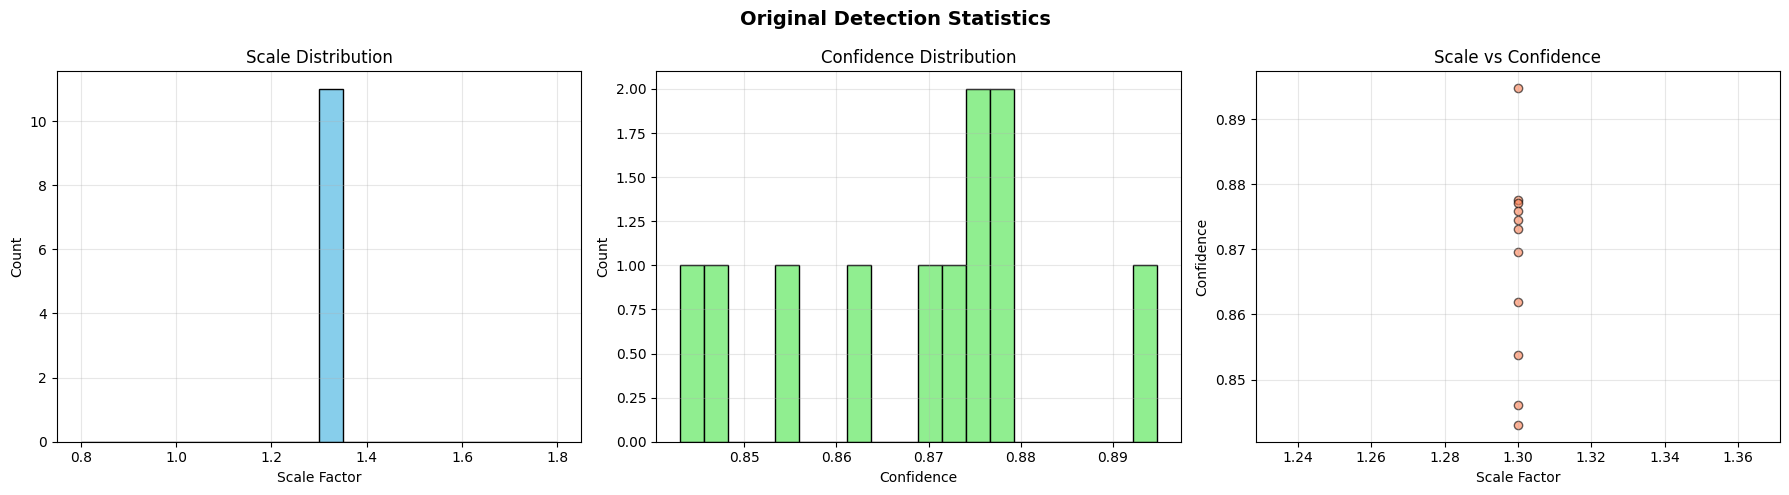


Original Detection Statistics
Total detections: 11
Confidence range: 0.843 - 0.895
Average confidence: 0.868
Scale range: 1.30 - 1.30

Detections per scale:
  Scale 1.30x: 11 detections



In [16]:
print("Original Detection Results:")
visualize_detection_stats(icon_detections, title="Original Detection Statistics")



Original Detection Results:


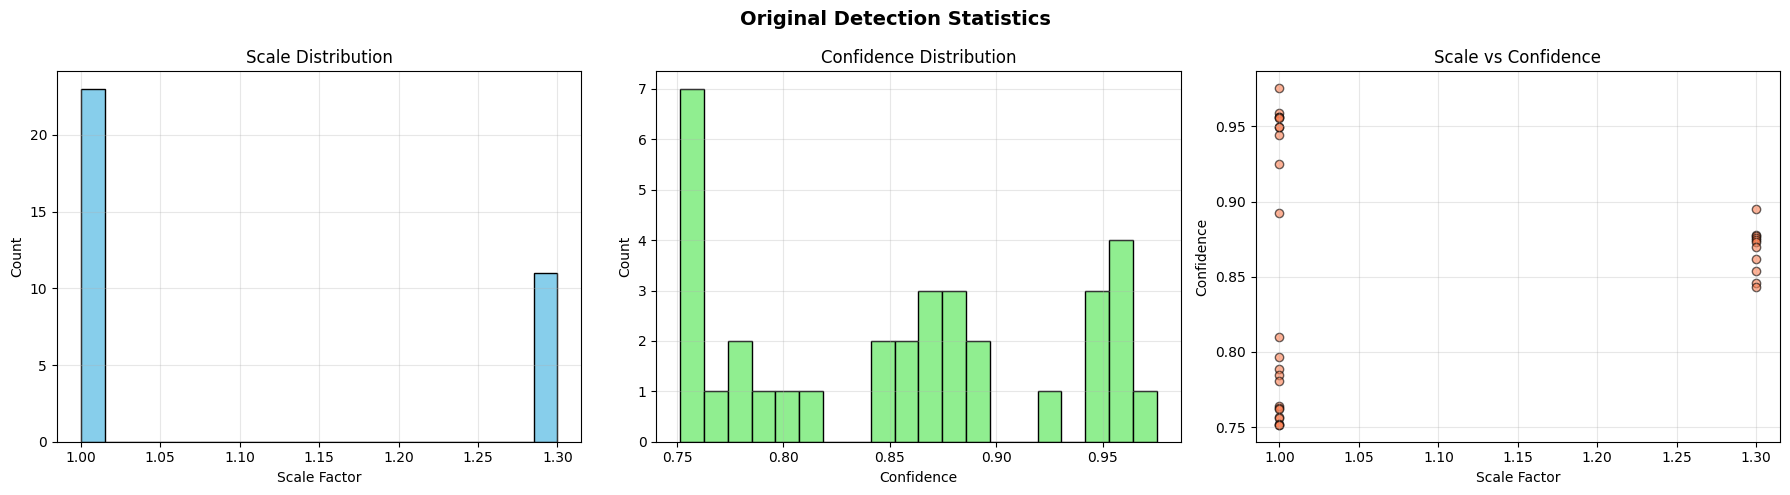


Original Detection Statistics
Total detections: 34
Confidence range: 0.751 - 0.975
Average confidence: 0.854
Scale range: 1.00 - 1.30

Detections per scale:
  Scale 1.00x: 23 detections
  Scale 1.30x: 11 detections



In [17]:
print("Original Detection Results:")
visualize_detection_stats(all_detections, title="Original Detection Statistics")


In [18]:
from utils.Icon_Text_Label_Matcher import (
    match_icons_to_tags,
    draw_labeled_results,
    filter_by_confidence,
    print_summary
)

In [19]:
image = cv2.imread(search_image_path)
h, w = image.shape[:2]


# 2. Run matching (use your existing all_detections list)
labeled_icons, unassigned_tags, debug_info = match_icons_to_tags(
    all_detections=all_detections,  # Your Detection list
    image_shape=(h, w),      # (height, width)
    confidence_threshold=0.60,       # Adjust as needed
    enable_debug=True
)



ADVANCED ICON-TAG MATCHING
Icons: 11, Tags: 23
Image shape: 10800x7200
Confidence threshold: 0.6
Minimum votes required: 4/6
--------------------------------------------------------------------------------

🔍 Computing multi-technique votes...

🎯 Performing one-to-one matching...

✅ Matched 10 icon(s) to tags
❓ 1 icon(s) remain unknown
🏷️  13 tag(s) unassigned

ASSIGNMENT DETAILS:
✓ Icon at (np.int64(5206), np.int64(6199)) → 'BF3' (vote=0.799, dist=114.3px)
✓ Icon at (np.int64(5564), np.int64(4654)) → 'BF3' (vote=0.798, dist=116.1px)
✓ Icon at (np.int64(5013), np.int64(5535)) → 'BF3' (vote=0.793, dist=118.1px)
✓ Icon at (np.int64(6339), np.int64(4654)) → 'BF3' (vote=0.793, dist=118.3px)
✓ Icon at (np.int64(7247), np.int64(4697)) → 'BF3' (vote=0.785, dist=121.3px)
✓ Icon at (np.int64(4022), np.int64(4654)) → 'BF3' (vote=0.785, dist=121.5px)
✓ Icon at (np.int64(5187), np.int64(4079)) → 'CF1' (vote=0.731, dist=117.7px)
✓ Icon at (np.int64(5968), np.int64(3650)) → 'CF1' (vote=0.717, dist=1

In [20]:
# Step 2: Summary
print_summary(labeled_icons, unassigned_tags)

# Step 3: Visualize
draw_labeled_results(
    image_path=search_image_path,
    labeled_icons=labeled_icons,
    unassigned_tags=unassigned_tags,
    output_path="output_5.png"
)


MATCHING SUMMARY

Total icons: 11
  • BF3: 7 (avg confidence: 0.779)
  • CF1: 2 (avg confidence: 0.724)
  • CF2: 1 (avg confidence: 0.690)
  • unknown: 1

Unassigned tags: 13
  • CF1 - best icon already assigned to different tag
  • CF1 - best icon already assigned to different tag
  • CF1 - insufficient vote with best icon (0.277)
  • CF1 - best icon already assigned to different tag
  • CF1 - insufficient vote with best icon (0.270)
  • CF1 - best icon already assigned to different tag
  • CF1 - best icon already assigned to different tag
  • CF1 - best icon already assigned to different tag
  • CF2 - best icon already assigned to different tag
  • CF2 - best icon already assigned to different tag
  • CF2 - best icon already assigned to different tag
  • CF2 - best icon already assigned to different tag
  • CF2 - best icon already assigned to different tag

✅ Annotated image saved: output_5.png
   Resolution: 10800x7200
   Labeled icons: 11
   Unassigned tags: 13


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [21]:
# 3. Get results
for icon in labeled_icons:
    print(f"Icon: {icon.bbox}")
    print(f"  Label: {icon.assigned_label}")
    print(f"  Label confidence: {icon.label_confidence}")

Icon: (np.int64(5128), np.int64(6120), 157, 158)
  Label: BF3
  Label confidence: 0.7986978975497144
Icon: (np.int64(5486), np.int64(4575), 157, 158)
  Label: BF3
  Label confidence: 0.7979949506489186
Icon: (np.int64(4935), np.int64(5456), 157, 158)
  Label: BF3
  Label confidence: 0.7927256006246091
Icon: (np.int64(6261), np.int64(4575), 157, 158)
  Label: BF3
  Label confidence: 0.7926800801423842
Icon: (np.int64(7169), np.int64(4618), 157, 158)
  Label: BF3
  Label confidence: 0.7850144839945339
Icon: (np.int64(3944), np.int64(4575), 157, 158)
  Label: BF3
  Label confidence: 0.7849695019516602
Icon: (np.int64(5109), np.int64(4000), 157, 158)
  Label: CF1
  Label confidence: 0.7310888075137066
Icon: (np.int64(5890), np.int64(3571), 157, 158)
  Label: CF1
  Label confidence: 0.7173095119401903
Icon: (np.int64(3576), np.int64(3772), 157, 158)
  Label: BF3
  Label confidence: 0.7008893058843798
Icon: (np.int64(7150), np.int64(3940), 157, 158)
  Label: CF2
  Label confidence: 0.6904410

In [22]:


# Step 4: Filter for LLM verification
high_conf, low_conf = filter_by_confidence(labeled_icons, min_confidence=0.65)
print(f"Send {len(low_conf)} icons to LLM")

Send 1 icons to LLM


In [46]:
def draw_labeled_results(
    image_path: str,
    labeled_icons: List[LabeledIcon],
    unassigned_tags: List[UnassignedTag],
    output_path: str,
    show_confidence: bool = True,
    show_unassigned_tags: bool = True
) -> np.ndarray:
    """
    Draw bounding boxes with labels and confidence scores on the image.
    
    Args:
        image_path: Path to the input image
        labeled_icons: List of LabeledIcon objects
        unassigned_tags: List of UnassignedTag objects
        output_path: Path to save the annotated image
        show_confidence: Whether to show confidence scores
        show_unassigned_tags: Whether to draw unassigned tags
    
    Returns:
        Annotated image as numpy array
    
    Example:
        >>> result_img = draw_labeled_results(
        ...     image_path="input.png",
        ...     labeled_icons=labeled_icons,
        ...     unassigned_tags=unassigned_tags,
        ...     output_path="result.png"
        ... )
    """
    import cv2
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    result = image.copy()
    img_h, img_w = image.shape[:2]
    
    # Calculate adaptive sizes based on image resolution
    line_thickness = max(1, int((img_h + img_w) / 3000))
    dot_radius = max(3, int((img_h + img_w) / 4000))
    font_scale = max(0.2, line_thickness * 0.125)
    font_thickness = max(1, line_thickness // 2)
    
    # Define color palette
    color_palette = {
        'unknown': (0, 0, 255),       # Red for unknown
        'default': (0, 255, 0),       # Green default
        'high_conf': (0, 255, 0),     # Green for high confidence
        'medium_conf': (0, 165, 255), # Orange for medium confidence
        'low_conf': (0, 100, 255),    # Dark orange for low confidence
        'unassigned_tag': (255, 0, 255),  # Magenta for unassigned tags
    }
    
    # Build unique label colors
    unique_labels = set([icon.assigned_label for icon in labeled_icons if icon.assigned_label != "unknown"])
    label_specific_colors = [
        (0, 255, 0), (255, 0, 0), (0, 165, 255), (255, 0, 255),
        (0, 255, 255), (255, 128, 0), (128, 0, 255),
        (0, 128, 255), (255, 255, 0), (128, 255, 0),
    ]
    
    label_colors = {}
    for i, label in enumerate(sorted(unique_labels)):
        label_colors[label] = label_specific_colors[i % len(label_specific_colors)]
    
    # Draw icons
    for icon in labeled_icons:
        x, y, w, h = icon.bbox
        label = icon.assigned_label
        bbox_conf = icon.bbox_confidence
        label_conf = icon.label_confidence
        
        # Choose color based on label and confidence
        if label == "unknown":
            color = color_palette['unknown']
        else:
            # Use label-specific color, but modify brightness based on confidence
            if label_conf >= 0.7:
                color = label_colors[label]
            elif label_conf >= 0.5:
                # Slightly darker for medium confidence
                base_color = label_colors[label]
                color = tuple(int(c * 0.8) for c in base_color)
            else:
                # Much darker for low confidence
                base_color = label_colors[label]
                color = tuple(int(c * 0.6) for c in base_color)
        
        # Draw bounding box
        alpha1 = 0.2
        overlay = result.copy()

        cv2.rectangle(overlay, (x, y), (x + w, y + h), color, -1)
        cv2.addWeighted(overlay, alpha1, result, 1 - alpha1, 0, result)
        # cv2.rectangle(result, (x, y), (x + w, y + h), color, line_thickness)

        # Draw center point
        cv2.circle(result, icon.center, dot_radius, color, -1)
        cv2.circle(result, icon.center, dot_radius + 1, (0, 0, 0), 1)
        
        # Prepare label text
        if label == "unknown":
            text = "?"
            if show_confidence:
                text = f"? ({bbox_conf:.2f})"
        else:
            text = label
            if show_confidence:
                text = f"{label} ({label_conf:.2f})"
        
        # Calculate text size and position
        (text_w, text_h), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
        )
        
        # Position text above bbox, or below if too close to top
        text_x = x
        text_y = y - baseline - 5
        if text_y - text_h < 0:
            text_y = y + h + text_h + baseline + 5
        
        # Draw semi-transparent background for text
        # overlay = result.copy()
        # padding = 4
        # cv2.rectangle(
        #     overlay,
        #     (text_x - 2, text_y - text_h - baseline - 2),
        #     (text_x + text_w + padding, text_y + baseline + 2),
        #     color,
        #     -1
        # )
        # cv2.addWeighted(overlay, 0.6, result, 0.4, 0, result)
        
        # Draw text
        cv2.putText(
            overlay,
            text,
            (text_x + 2, text_y - 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            color,
            font_thickness,
            cv2.LINE_AA
        )

        # Blend with transparency
        alpha = 0.5   # 0 = fully transparent, 1 = solid
        cv2.addWeighted(overlay, alpha, result, 1 - alpha, 0, result)
    
    # Draw unassigned tags (if enabled)
    if show_unassigned_tags:
        for tag in unassigned_tags:
            x, y, w, h = tag.bbox
            color = color_palette['unassigned_tag']
            
            # Draw with dashed style (smaller thickness)
            dash_length = line_thickness * 3
            
            # Top edge (dashed)
            for i in range(x, x + w, dash_length * 2):
                cv2.line(result, (i, y), (min(i + dash_length, x + w), y), color, line_thickness)
            
            # Bottom edge (dashed)
            for i in range(x, x + w, dash_length * 2):
                cv2.line(result, (i, y + h), (min(i + dash_length, x + w), y + h), color, line_thickness)
            
            # Left edge (dashed)
            for i in range(y, y + h, dash_length * 2):
                cv2.line(result, (x, i), (x, min(i + dash_length, y + h)), color, line_thickness)
            
            # Right edge (dashed)
            for i in range(y, y + h, dash_length * 2):
                cv2.line(result, (x + w, i), (x + w, min(i + dash_length, y + h)), color, line_thickness)
            
            # Draw center point
            cv2.circle(result, tag.center, dot_radius, color, -1)
            cv2.circle(result, tag.center, dot_radius + 1, (0, 0, 0), 1)
            
            # Draw tag name
            text = f"[{tag.tag_name}]"
            if show_confidence:
                text = f"[{tag.tag_name}] ({tag.confidence:.2f})"
            
            (text_w, text_h), baseline = cv2.getTextSize(
                text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
            )
            
            text_x = x
            text_y = y - baseline - 5
            if text_y - text_h < 0:
                text_y = y + h + text_h + baseline + 5
            
            # Background
            overlay = result.copy()
            cv2.rectangle(
                overlay,
                (text_x - 2, text_y - text_h - baseline - 2),
                (text_x + text_w + 4, text_y + baseline + 2),
                color,
                -1
            )
            cv2.addWeighted(overlay, 0.5, result, 0.5, 0, result)
            
            # Text
            cv2.putText(
                result,
                text,
                (text_x + 2, text_y - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                font_scale,
                (255, 255, 255),
                font_thickness,
                cv2.LINE_AA
            )
    
    # Add legend in top-left corner
    legend_y = 30
    legend_x = 20
    legend_font_scale = font_scale * 1.2
    legend_thickness = font_thickness + 1
    
    # Draw semi-transparent background for legend
    legend_items = []
    if any(icon.assigned_label != "unknown" for icon in labeled_icons):
        legend_items.append(("Labeled Icons:", (255, 255, 255)))
        
        for label in sorted(unique_labels):
            count = sum(1 for icon in labeled_icons if icon.assigned_label == label)
            legend_items.append((f"  {label}: {count}", label_colors[label]))
    
    unknown_count = sum(1 for icon in labeled_icons if icon.assigned_label == "unknown")
    if unknown_count > 0:
        legend_items.append((f"Unknown: {unknown_count}", color_palette['unknown']))
    
    if show_unassigned_tags and unassigned_tags:
        legend_items.append((f"Unassigned Tags: {len(unassigned_tags)}", color_palette['unassigned_tag']))
    
    if legend_items:
        max_text_w = 0
        total_h = 0
        for text, _ in legend_items:
            (text_w, text_h), _ = cv2.getTextSize(
                text, cv2.FONT_HERSHEY_SIMPLEX, legend_font_scale, legend_thickness
            )
            max_text_w = max(max_text_w, text_w)
            total_h += text_h + 10
        
        overlay = result.copy()
        cv2.rectangle(
            overlay,
            (legend_x - 10, legend_y - 20),
            (legend_x + max_text_w + 20, legend_y + total_h + 10),
            (0, 0, 0),
            -1
        )
        cv2.addWeighted(overlay, 0.7, result, 0.3, 0, result)
        
        current_y = legend_y
        for text, color in legend_items:
            cv2.putText(
                result,
                text,
                (legend_x, current_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                legend_font_scale,
                color,
                legend_thickness,
                cv2.LINE_AA
            )
            current_y += int((legend_font_scale * 30) + 10)
    
    # Save result
    cv2.imwrite(output_path, result)
    print(f"\n✅ Annotated image saved: {output_path}")
    print(f"   Resolution: {img_w}x{img_h}")
    print(f"   Labeled icons: {len(labeled_icons)}")
    print(f"   Unassigned tags: {len(unassigned_tags)}")
    
    return result

In [ ]:
# Export to CSV
import pandas as pd

# Create dataframe
data = []
for idx, det in enumerate(detections):
    x, y, w, h = det.bbox
    cx, cy = det.center
    data.append({
        'Symbol_ID': idx + 1,
        'Center_X': cx,
        'Center_Y': cy,
        'BBox_X': x,
        'BBox_Y': y,
        'BBox_Width': w,
        'BBox_Height': h,
        'Confidence': det.confidence,
        'Scale': det.scale,
        'Rotation': det.rotation
    })

df = pd.DataFrame(data)

# Save to CSV
csv_path = image_path.rsplit('.', 1)[0] + '_detections.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Detection data exported to: {csv_path}")

# Display dataframe
print("\nDetection Data:")
display(df)